In [1]:
# Load libraries
import torch 
import pandas as pd 
import numpy as np
import json
import tokenizers


from torch import tensor
from torch.utils.data import DataLoader, Dataset
from transformers import  RobertaConfig
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.models import WordLevel, BPE
from tokenizers import pre_tokenizers, normalizers, Tokenizer
from tokenizers.normalizers import Lowercase, NFD
from tokenizers.pre_tokenizers import ByteLevel, Whitespace
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from utils.utils import prob2label
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [2]:
# Load settings
with open('settings.json', 'r') as inFile:
    settings = json.load(inFile)
    
# Set device 
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load model
model = torch.load('best_model_test')
model.to(device)
model.eval()

Net(
  (roberta_embeddings_alpha): RobertaEmbeddings(
    (word_embeddings): Embedding(25, 1032, padding_idx=1)
    (position_embeddings): Embedding(512, 1032, padding_idx=1)
    (token_type_embeddings): Embedding(2, 1032)
    (LayerNorm): LayerNorm((1032,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (roberta_embeddings_beta): RobertaEmbeddings(
    (word_embeddings): Embedding(25, 1032, padding_idx=1)
    (position_embeddings): Embedding(512, 1032, padding_idx=1)
    (token_type_embeddings): Embedding(2, 1032)
    (LayerNorm): LayerNorm((1032,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (roberta_encoding): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=1032, out_features=1032, bias=True)
            (key): Linear(in_features=1032, out_features=1032, bias=True)
 

In [3]:
model.classifier.weight

Parameter containing:
tensor([[ 0.0196, -0.0112,  0.0005,  ..., -0.0317, -0.0057, -0.0158],
        [-0.0289,  0.0024, -0.0380,  ...,  0.0174,  0.0181,  0.0207],
        [ 0.0224, -0.0057, -0.0153,  ...,  0.0055,  0.0028, -0.0274]],
       device='cuda:0', requires_grad=True)

In [4]:
class CDR3Dataset(Dataset):
    
    def __init__(self, settings:dict, train:bool = True, label:str = None, tokenizer:tokenizers.Tokenizer=None, equal:bool=False) -> None:
        cols = ["activatedby_HA", "activatedby_NP", "activatedby_HCRT", "activated_any", "multilabel", "negative"]
        if label not in cols:
            raise ValueError("Invalid label type. Expected one of %s" % cols)
        else: 
            self.label = label
        if equal and label == "num_label":
            raise ValueError("Equal size sets only allowed for binary classifications. num_label is multiclass.")
        
        if train == True:
            path_to_data = settings["file"]["train_data"] 
        else:
            path_to_data = settings["file"]["test_data"]   
              
        self.path_to_data = path_to_data
        self.data = pd.read_csv(self.path_to_data)
        if equal == True:
            min_sample=np.min(self.data[self.label].value_counts()) 
            data_pos = self.data[self.data[self.label]==1].sample(min_sample)
            data_neg = self.data[self.data[self.label]==0].sample(min_sample)
            self.data = pd.concat([data_pos, data_neg], ignore_index=True)
        
        if label == "multilabel":
            self.labels = [0,1]
            self.n_labels = 3
        else:
            self.labels = np.unique(self.data[[self.label]])
            self.n_labels = len(self.labels)
            
        self.max_len_CDRa = self.data.CDR3a.str.len().max()
        self.max_len_CDRb = self.data.CDR3b.str.len().max()
        self.max_len = max(self.max_len_CDRa, self.max_len_CDRb)
        
        self.tokenizer = tokenizer
        
    def __getitem__(self, index:int):
        if isinstance(self.tokenizer.model, tokenizers.models.WordLevel):
            self.tokenizer.enable_padding(length=self.max_len)
            CDR3a = " ".join(list(self.data.CDR3a[index]))
            CDR3b = " ".join(list(self.data.CDR3b[index]))
            encodings_CDR3a = self.tokenizer.encode(CDR3a)
            encodings_CDR3b = self.tokenizer.encode(CDR3b)
            item = {
                "ids_CDR3a":tensor(encodings_CDR3a.ids, dtype=torch.long),
                "ids_CDR3b":tensor(encodings_CDR3b.ids, dtype=torch.long),
                "attention_mask_CDR3a": tensor(encodings_CDR3a.attention_mask, dtype=torch.long),
                "attention_mask_CDR3b": tensor(encodings_CDR3b.attention_mask, dtype=torch.long),
                "CDR3a": self.data.CDR3a[index],
                "CDR3b": self.data.CDR3b[index]
                }
        elif isinstance(self.tokenizer.model, tokenizers.models.BPE):
            self.tokenizer.enable_padding(length=self.max_len)
            encodings_CDR3a = self.tokenizer.encode(self.data.CDR3a[index]) 
            encodings_CDR3b = self.tokenizer.encode(self.data.CDR3b[index]) 
            item = {
                "ids_CDR3a":tensor(encodings_CDR3a.ids, dtype=torch.long),
                "ids_CDR3b":tensor(encodings_CDR3b.ids, dtype=torch.long),
                "attention_mask_CDR3a": tensor(encodings_CDR3a.attention_mask, dtype=torch.long),
                "attention_mask_CDR3b": tensor(encodings_CDR3b.attention_mask, dtype=torch.long),
                "CDR3a": self.data.CDR3a[index],
                "CDR3b": self.data.CDR3b[index]
                }
        if self.label == "multilabel":
            item["target"]=tensor(self.data[["activatedby_HA", "activatedby_NP", "activatedby_HCRT"]].iloc[index],dtype =torch.long)
            item["label"]=(self.data["activated_by"].iloc[index])
        else:
            item["target"] = tensor(self.data[self.label][index], dtype=torch.long)
            item["label"]=(self.data["activated_by"].iloc[index])
        return item

    def __len__(self):
        return len(self.data)

In [6]:
# Create tonekizer from tokenizers library 
if settings["param"]["tokenizer"] == "BPE":
    tokenizer = Tokenizer(BPE()).from_file(settings["tokenizer"]["BPE"])
elif settings["param"]["tokenizer"] == "WL":
    tokenizer = Tokenizer(WordLevel()).from_file(settings["tokenizer"]["WL"])
else:
    raise ValueError("Unknown tokenizer. Tokenizer argument must be BPE or WL.")
tokenizer.enable_padding()
    
# Create training and test dataset
dataset_params={"label":settings["database"]["label"], "tokenizer":tokenizer}
train_data = CDR3Dataset(settings,train=True, equal=False, **dataset_params)
test_data =CDR3Dataset(settings, train=False, **dataset_params)

# Crate dataloaders
loader_params = {'batch_size': 1,
            'shuffle': False,
            'num_workers': 0
            }
train_dataloader = DataLoader(train_data, **loader_params)
test_dataloader = DataLoader(test_data, **loader_params)

In [11]:
# Get 10 random CDRs and predict 
sample_train = next(iter(train_dataloader))

# Predict 
torch.cuda.empty_cache() 
model.eval()
outs_df = []
ids_CDR3a, ids_CDR3b = sample_train["ids_CDR3a"].to(device), sample_train["ids_CDR3b"].to(device)
targets = sample_train["target"].to(device)
outs = model(ids_CDR3a, ids_CDR3b)

# Bring to CPU 
targets = targets.to('cpu') .detach().numpy()
outs = outs.to('cpu')
outs = outs.detach().numpy()
outs = np.around(outs, decimals=3) 

cols_prob = ["PROB_activatedby_HA", "PROB_activatedby_NP", "PROB_activatedby_HCRT"]
cols = ["activatedby_HA", "activatedby_NP", "activatedby_HCRT"]

# Crate dataframes 
outs_df = pd.DataFrame.from_records(outs)
outs_df.columns = cols_prob

# Crate dataframe of targets
targets_df = pd.DataFrame.from_records(targets)
targets_df.columns = cols
targets_df.insert(0, 'CDR3a', sample_train['CDR3a'])
targets_df.insert(1, 'CDR3b', sample_train['CDR3b'])


# Concat 
comp_df = pd.concat([targets_df, outs_df], axis=1)
comp_df



,CDR3a,CDR3b,activatedby_HA,activatedby_NP,activatedby_HCRT,PROB_activatedby_HA,PROB_activatedby_NP,PROB_activatedby_HCRT
0,CILQTQGGSEKLVF,CASSIGTSVAGYTF,0,1,0,0.0,1.0,0.0


In [8]:

# Get 10 random CDRs and predict 
sample_test = next(iter(test_dataloader))

# Predict 
model.eval()
outs_df = []
ids_CDR3a, ids_CDR3b = sample_test["ids_CDR3a"].to(device), sample_test["ids_CDR3b"].to(device)
targets = sample_test["target"].to(device)
outs = model(ids_CDR3a, ids_CDR3b )

# Bring to CPU 
targets = targets.to('cpu') .detach().numpy()
outs = outs.to('cpu')
outs = outs.detach().numpy()
outs = np.around(outs, decimals=3) 

cols_prob = ["PROB_activatedby_HA", "PROB_activatedby_NP", "PROB_activatedby_HCRT"]
cols = ["activatedby_HA", "activatedby_NP", "activatedby_HCRT"]

# Crate dataframes 
outs_df = pd.DataFrame.from_records(outs)
outs_df.columns = cols_prob

# Crate dataframe of targets
targets_df = pd.DataFrame.from_records(targets)
targets_df.columns = cols
targets_df.insert(0, 'CDR3a', sample_train['CDR3a'])
targets_df.insert(1, 'CDR3b', sample_train['CDR3b'])

# Concat 
comp_df = pd.concat([targets_df, outs_df], axis=1)
comp_df



,CDR3a,CDR3b,activatedby_HA,activatedby_NP,activatedby_HCRT,PROB_activatedby_HA,PROB_activatedby_NP,PROB_activatedby_HCRT
0,CILQTQGGSEKLVF,CILQTQGGSEKLVF,0,0,0,0.000,0.000,0.000
1,CVVSDLPPGGKLIF,CVVSDLPPGGKLIF,0,0,0,0.000,0.000,0.000
2,CAVKTGGFKTIF,CAVKTGGFKTIF,0,1,0,0.000,0.000,0.135
3,CAGDTASKLTF,CAGDTASKLTF,0,1,0,0.000,1.000,0.000
4,CAVDRYGNKLVF,CAVDRYGNKLVF,0,1,0,0.000,1.000,0.000
5,CVVIYGSYDKVIF,CVVIYGSYDKVIF,1,0,0,1.000,0.000,0.000
6,CAVEERNARLMF,CAVEERNARLMF,1,0,0,0.037,0.000,0.000
7,CAFPSTGNQFYF,CAFPSTGNQFYF,1,0,0,0.000,0.000,0.000
8,CIVRVAGKAAGNKLTF,CIVRVAGKAAGNKLTF,0,0,0,0.000,0.000,0.003
9,CIRGESGGSNYKLTF,CIRGESGGSNYKLTF,0,0,0,0.000,0.000,0.000


In [9]:
# Train data 
train_data.data.activated_by.value_counts()

negative    2742
NP136        772
HA69         511
HCRT         292
Name: activated_by, dtype: int64

In [10]:
train_data.data.shape[0]

4317

In [11]:
test_data.data.activated_by.value_counts()

negative    1166
NP136        359
HA69         216
HCRT         123
Name: activated_by, dtype: int64

In [12]:
test_data.data.shape[0]

1864

In [13]:
test_data.data.activatedby_NP.value_counts()

0    1505
1     359
Name: activatedby_NP, dtype: int64

In [14]:
# Get all predictions for test and train set 
out_labels_train, outputs_train = [], [], 
targets_train = []
model.eval()

for data in train_dataloader:
    ids_CDR3a, ids_CDR3b = data["ids_CDR3a"].to(device), data["ids_CDR3b"].to(device)
    targets = data["target"].to(device)
    outs = model(ids_CDR3a, ids_CDR3b)
    targets = targets.to('cpu') .detach().numpy().tolist()
    outs = outs.to('cpu').detach().numpy()
    out_labels_train += prob2label(outs, threshold=0.5)
    targets_train += targets
    outputs_train += outs.tolist()


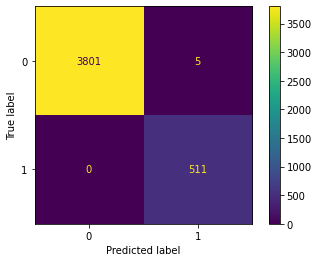

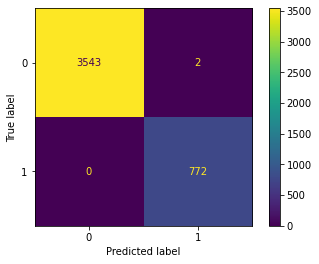

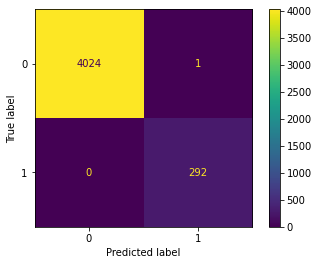

In [15]:
mlcf = multilabel_confusion_matrix(np.array(targets_train), np.array(out_labels_train))
%matplotlib inline
for i in range(len(mlcf)):
    disp = ConfusionMatrixDisplay(mlcf[i], )
    disp.plot()


In [16]:
outputs_test, out_labels_test= [], []
targets_test = []
# Get all predictions for test and train set 
for data in test_dataloader:
    ids_CDR3a, ids_CDR3b = data["ids_CDR3a"].to(device), data["ids_CDR3b"].to(device)
    targets = data["target"].to(device)
    outs = model(ids_CDR3a, ids_CDR3b)
    targets = targets.to('cpu').detach().numpy().tolist()
    outs = outs.to('cpu').detach().numpy()
    outs = np.around(outs, decimals=3)
    out_labels_test += prob2label(outs, threshold=0.5)
    targets_test += targets
    outputs_test += outs.tolist()

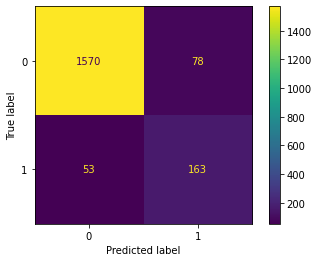

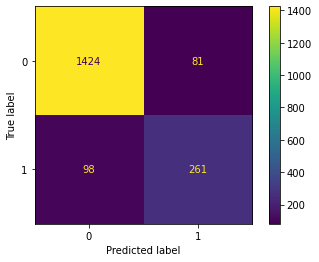

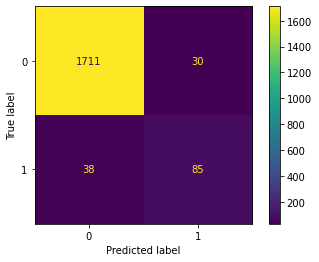

In [17]:
mlcf = multilabel_confusion_matrix(np.array(targets_test), np.array(out_labels_test))

%matplotlib inline
for i in range(len(mlcf)):
    disp = ConfusionMatrixDisplay(mlcf[i])
    disp.plot()

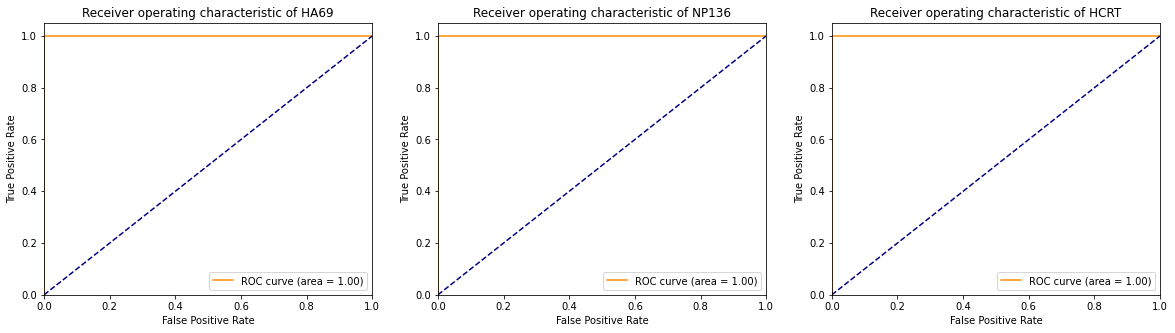

In [18]:
# Roc curve train 
out_train_flat = list(map(list, zip(*outputs_train)))
targets_train_flat = list(map(list, zip(*targets_train)))

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
for i, peptide in zip(range(len(out_train_flat)), ['HA69','NP136', 'HCRT']):
    fpr, tpr, _ = roc_curve(targets_train_flat[i], out_train_flat[i])
    plt.subplot(1,3, i+1)
    plt.plot(fpr,tpr,color="darkorange",label="ROC curve (area = %0.2f)" % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic of " + peptide)
    plt.legend(loc="lower right")
plt.show()

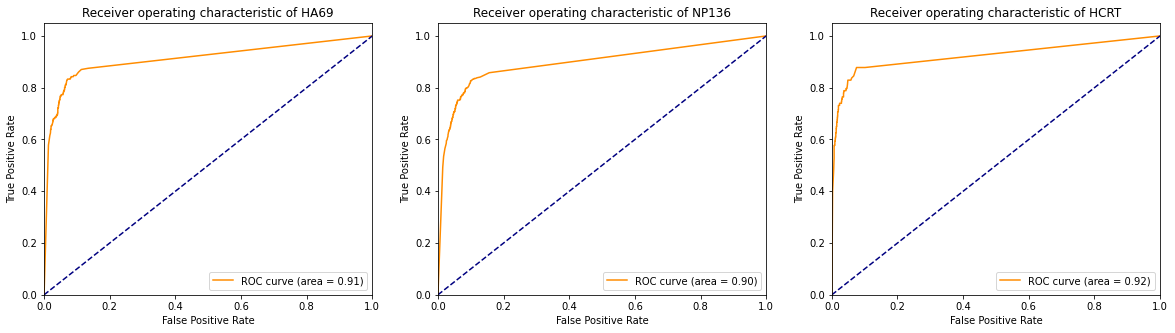

In [19]:
# Roc curve test 
out_test_flat = list(map(list, zip(*outputs_test)))
targets_test_flat = list(map(list, zip(*targets_test)))

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
for i, peptide in zip(range(len(out_train_flat)), ['HA69','NP136', 'HCRT']):
    fpr, tpr, _ =roc_curve(targets_test_flat[i], out_test_flat[i])
    plt.subplot(1,3, i+1)
    plt.plot(fpr,tpr,color="darkorange",label="ROC curve (area = %0.2f)" % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic of " + peptide)
    plt.legend(loc="lower right")
plt.show()

In [77]:
# Create model for visualization and remove pre-classifier and classifier
model_viz = model
model_viz.pre_classifier = torch.nn.Identity()
model_viz.dropout = torch.nn.Identity()
model_viz.classifier = torch.nn.Identity()



In [78]:
# Get all the representations of the train set
train_reps = []
targets_train = []
labels_train = []
model_viz.eval()

for data in train_dataloader:
    ids_CDR3a, ids_CDR3b = data["ids_CDR3a"].to(device), data["ids_CDR3b"].to(device)
    targets = data["target"].to(device)
    labels_train += data["label"]
    outs = model_viz(ids_CDR3a, ids_CDR3b)
    targets = targets.to('cpu') .detach().numpy().tolist()
    outs = outs.to('cpu').detach().numpy().tolist()
    targets_train += targets
    train_reps += outs


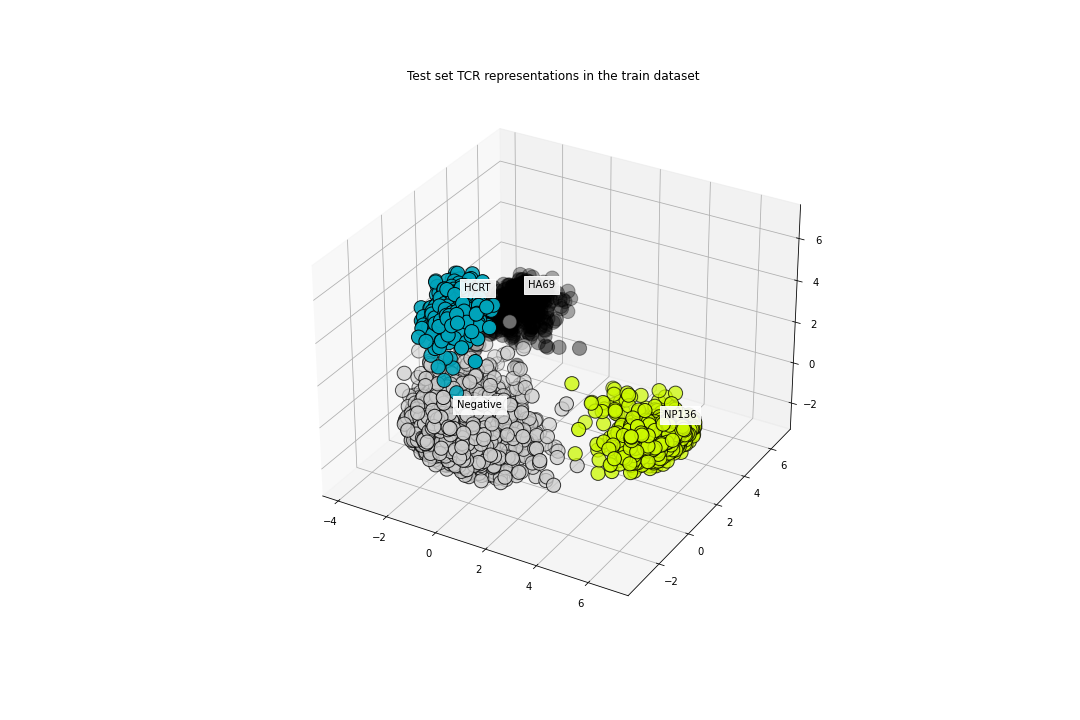

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from numpy.random import rand
from IPython.display import HTML
from matplotlib import animation
TOKENIZERS_PARALLELISM=False
# PCA on train dataset
pca = PCA(n_components=3)
pca.fit(train_reps)
train_transform = pca.transform(train_reps)

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_train)
labels_num = label_encoder.transform(labels_train) 

%matplotlib widget
fig = plt.figure(1, figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
for name, label in [("HA69", 0), ("HCRT", 1), ("NP136", 2), ("Negative",3)]:
    ax.text3D(
        train_transform[labels_num == label, 0].mean(),
        train_transform[labels_num == label, 1].mean() + 1.5,
        train_transform[labels_num == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.9, edgecolor="w", facecolor="w"))
ax.set_title("Test set TCR representations in the train dataset")
ax.scatter(train_transform[:, 0], train_transform[:, 1], train_transform[:, 2], cmap=plt.cm.nipy_spectral, c=labels_num, edgecolor="k",  s=200)

In [23]:
# Get all the representations of the train set
test_reps = []
targets_test = []
labels_test = []
model.eval()

for data in test_dataloader:
    ids_CDR3a, ids_CDR3b = data["ids_CDR3a"].to(device), data["ids_CDR3b"].to(device)
    targets = data["target"].to(device)
    labels_test += data["label"]
    outs = model_viz(ids_CDR3a, ids_CDR3b)
    targets = targets.to('cpu') .detach().numpy().tolist()
    outs = outs.to('cpu').detach().numpy().tolist()
    out_labels_test += prob2label(outs, threshold=0.5)
    targets_test += targets
    test_reps += outs

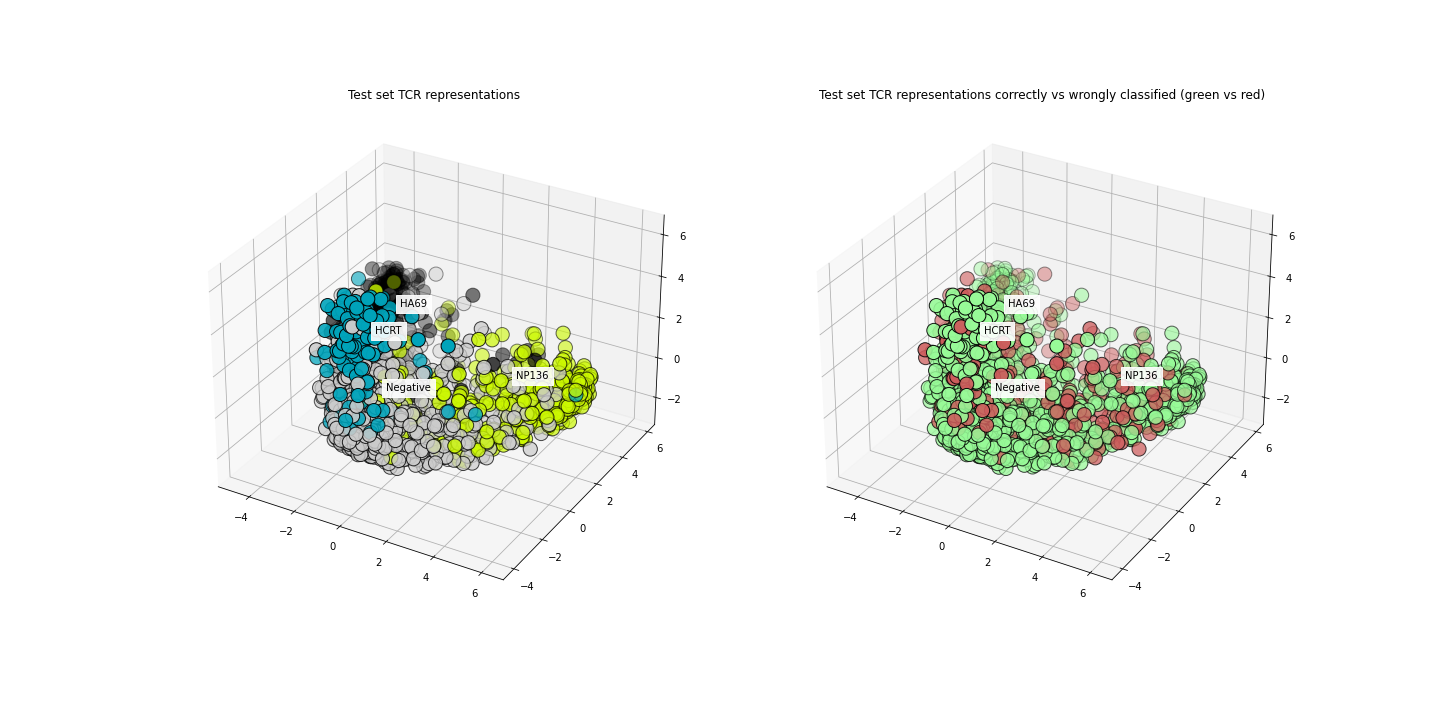

In [24]:
import matplotlib

# PCA on train dataset
pca = PCA(n_components=3)
pca.fit(test_reps)
test_transform = pca.transform(test_reps)

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_test)
labels_num = label_encoder.transform(labels_test) 

label_class = [1 if y_pred == y_true else 0 for y_pred, y_true in zip(out_labels_test, targets_test)]

%matplotlib widget 
fig = plt.figure(1, figsize=(20,10))
ax = fig.add_subplot(121, projection='3d')
for name, label in [("HA69", 0), ("HCRT", 1), ("NP136", 2), ("Negative",3)]:
    ax.text3D(
        test_transform[labels_num == label, 0].mean(),
        test_transform[labels_num == label, 1].mean() + 1.5,
        test_transform[labels_num == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.9, edgecolor="w", facecolor="w"),
    )
ax.set_title("Test set TCR representations")
ax.scatter(test_transform[:, 0], test_transform[:, 1], test_transform[:, 2], cmap=plt.cm.nipy_spectral, edgecolor="k", c=labels_num, s=200)
ax = fig.add_subplot(122, projection='3d')
for name, label in [("HA69", 0), ("HCRT", 1), ("NP136", 2), ("Negative",3)]:
    ax.text3D(
        test_transform[labels_num == label, 0].mean(),
        test_transform[labels_num == label, 1].mean() + 1.5,
        test_transform[labels_num == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.9, edgecolor="w", facecolor="w"),
    )
ax.set_title("Test set TCR representations correctly vs wrongly classified (green vs red)")
ax.scatter(test_transform[:, 0], test_transform[:, 1], test_transform[:, 2], cmap=matplotlib.colors.ListedColormap(['indianred', 'palegreen']), edgecolor="k", c=label_class, s=200)
plt.show()

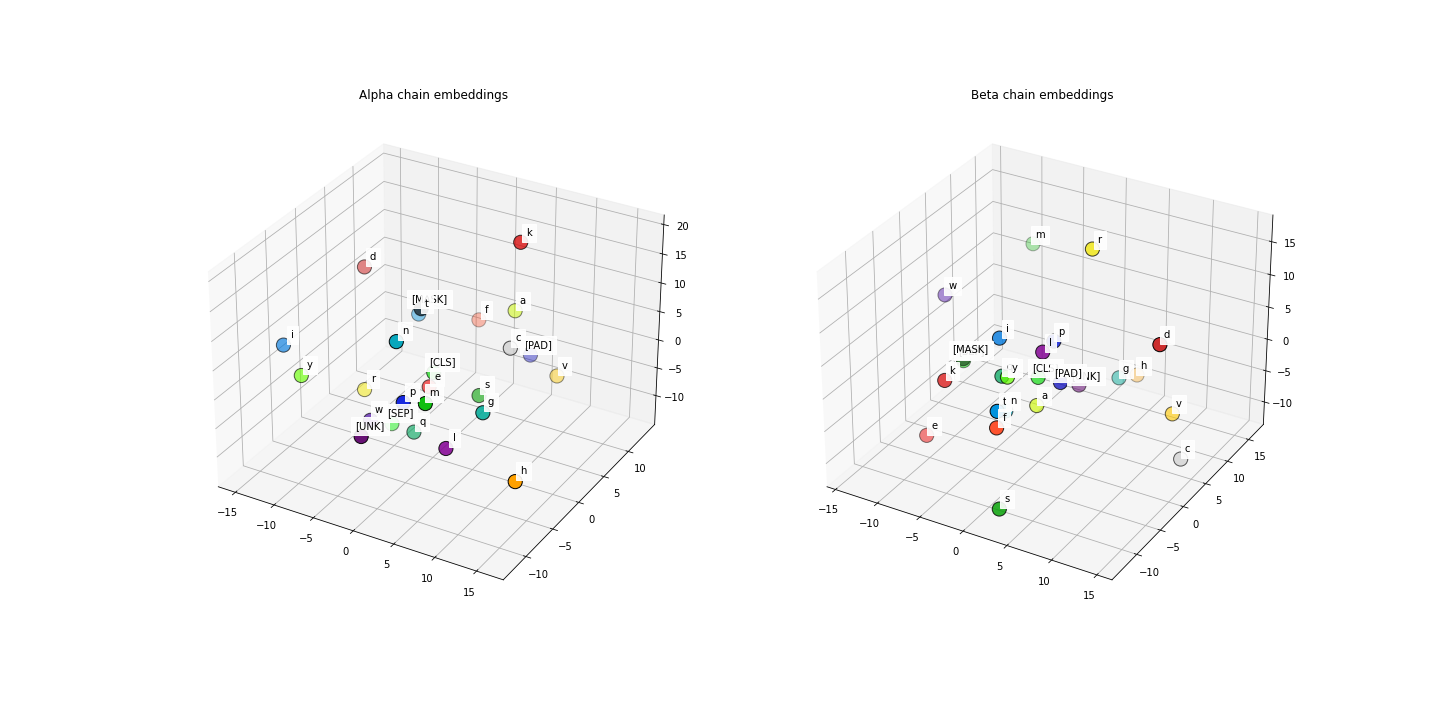

In [25]:
# Create vocab 
vocab = tokenizer.get_vocab()
key_list_vocab = list(vocab.keys())
val_list_vocab = list(vocab.values())

# Check model embeddings
alpha_embedding_W = model.roberta_embeddings_alpha.word_embeddings.weight
alpha_embedding_W = alpha_embedding_W.detach().cpu().numpy()

# Compute PCA 
pca = PCA(n_components=3)
pca = pca.fit(alpha_embedding_W)
alpha_embedding_transW = pca.transform(alpha_embedding_W)

# Check model embeddings
beta_embedding_W = model.roberta_embeddings_beta.word_embeddings.weight
beta_embedding_W = beta_embedding_W.detach().cpu().numpy()

# Compute PCA 
pca = PCA(n_components=3)
pca = pca.fit(beta_embedding_W)
beta_embedding_transW = pca.transform(beta_embedding_W)

%matplotlib widget 
fig = plt.figure(1, figsize=(20,10))
ax = fig.add_subplot(121, projection='3d')
for i, aa_emb in enumerate(alpha_embedding_transW):
    name = key_list_vocab[val_list_vocab.index(i)]
    ax.text3D(
        alpha_embedding_transW[i, 0],
        alpha_embedding_transW[i, 1] + 1.5,
        alpha_embedding_transW[i, 2],
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.9, edgecolor="w", facecolor="w"),
    )
ax.set_title("Alpha chain embeddings")
ax.scatter(alpha_embedding_transW[:, 0], alpha_embedding_transW[:, 1], alpha_embedding_transW[:, 2], cmap=plt.cm.nipy_spectral, edgecolor="k", c=val_list_vocab, s=200)
ax = fig.add_subplot(122, projection='3d')
for i, aa_emb in enumerate(beta_embedding_transW):
    name = key_list_vocab[val_list_vocab.index(i)]
    ax.text3D(
        beta_embedding_transW[i, 0],
        beta_embedding_transW[i, 1] + 1.5,
        beta_embedding_transW[i, 2],
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.9, edgecolor="w", facecolor="w"),
    )
ax.set_title("Beta chain embeddings")
ax.scatter(beta_embedding_transW[:, 0], beta_embedding_transW[:, 1], beta_embedding_transW[:, 2], cmap=plt.cm.nipy_spectral, edgecolor="k", c=val_list_vocab, s=200)
plt.show()


        
    